# 輪郭に関するいろいろな関数
## 目的
このチュートリアルでは
* 凸性の欠陥とその検出方法について学ぶ．
* 点とポリゴン（多角形）の最短距離の計算方法を学ぶ．
* 形状のマッチングについて学ぶ．

## 理論と実装
### 1. 凸性の欠陥
以前の節で凸性について学んだ。内側に凹んでいれば凸性の欠陥という。この凸性の欠陥を見つけるための関数が <A HREF="http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.convex#cv2.convexityDefects" target="_blank">cv2.convexityDefects(contour, convexhull[, convexityDefects]) </A>である．使い方を次に示す:


```
hull = cv2.convexHull(cnt,returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)
```
<font color="blue">Note</font>:  凸性の欠陥検出をするためにはconvex hullの計算をする時に returnPoints = False とフラグを指定しなければならない．

戻り値はarray型のデータで，その各行は次の4つからなる: `[ 始点, 終点, 最も遠い点, 最も遠い点までの近似距離]`．これを画像を用いて説明しよう．まず初めに「始点」と「終点」を結ぶ線を引き，「最も遠い点」に円を描く．ここで最初の3個の値は cnt のインデックスであるため，それぞれの座標を得るには輪郭cntから取得しなければならないことに注意． (コードと使用する画像)

<font color="blue">注意</font>: OpenCV3ではOpenCV2と異なり<A HREF="http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.findcontours#findcontours" target="_blank"> cv2.findContours()</A>は2つではなく3つの値を返すため、 最初の戻り値は`_`にセットしている(つまり、その値を無視している)

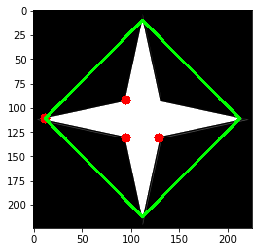

In [3]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('star.png')
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,2,1)
cnt = contours[0]

hull = cv2.convexHull(cnt,returnPoints = False)
defects = cv2.convexityDefects(cnt,hull)

for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    cv2.line(img,start,end,[0,255,0],2)
    cv2.circle(img,far,5,[0,0,255],-1)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
plt.show()

## 2. 点とポリゴン(多角形)のテスト
<A HREF="http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.pointpolygontest#cv2.pointPolygonTest" target="_blank">cv2.pointPolygonTest(contour, pt, measureDist)</A> 関数は点と輪郭を結ぶ最短距離を計算する関数である．指定された点ptが輪郭`contour`の外側にあれば負の値，内側にあれば正の値，輪郭上にあれば`0`を返す．

第3引数`measureDist` は ， `True`であれば符号付き距離を計算し，` False` を指定すると`+1`，`-1`， `0`(それぞれ輪郭の内側，外側，輪郭上)のどれかの値を返す．

点(50,50)をテストする場合を例に示す:

In [4]:
dist = cv2.pointPolygonTest(cnt,(50,50),True)
print(dist)

-51.66236541235796


Note 距離の計算は時間がかかる処理なので、距離が必要なければ第3引数に `False` を指定する． 実際、`False` を指定すると2，3倍高速になる．

In [5]:
%timeit dist = cv2.pointPolygonTest(cnt,(50,50),True)

7.15 µs ± 50.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
%timeit dist = cv2.pointPolygonTest(cnt,(50,50),False)

3.01 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## 3. 形状のマッチング
<A HREF="http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.matchshapes#cv2.matchShapes" target="_blank">cv2.matchShapes(contour1, contour2, method, parameter)</A> 関数を使うと二つの形状(もしくは輪郭)をマッチングし，モーメントの値を基にして計算した形状の差を表す数値を返す．数値が小さいほど二つの形状が似ていることを表す．その計算方法にはいろいろなものがあり、第３引数で選択でき、`CV_CONTOURS_MATCH_I1` , `CV_CONTOURS_MATCH_I2`, `CV_CONTOURS_MATCH_I3`が選択できる(詳しくはドキュメントを参照のこと)．これらの方法はみな Huモーメントを利用している.

In [9]:
import cv2
import numpy as np

img1 = cv2.imread('star.png',0)
img2 = cv2.imread('star2.png',0)

ret, thresh = cv2.threshold(img1, 127, 255,0)
ret, thresh2 = cv2.threshold(img2, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,2,1)
cnt1 = contours[0]
_, contours,hierarchy = cv2.findContours(thresh2,2,1)
cnt2 = contours[0]

ret = cv2.matchShapes(cnt1,cnt2,1,0.0)
print (ret)

0.0


形状のマッチングを以下の形状を使って試してみよう:  <A HREF="http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/star2.png">画像A</A>,  <A HREF="http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/star3.png">画像B</A>, <A HREF="http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/star4.png">画像C</A>)

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/matchshapes.jpg)

In [13]:
%matplotlib inline
import cv2
import numpy as np

imageName = {2:'A', 3:'B',4:'C'}

img1 = cv2.imread('star2.png',0)
ret, thresh = cv2.threshold(img1, 127, 255,0)
_, contours,hierarchy = cv2.findContours(thresh,2,1)
cnt1 = contours[0]

for num in range(2,5):
   img2 = cv2.imread('star'+str(num)+'.png',0)
   ret, thresh2 = cv2.threshold(img2, 127, 255,0)
   _, contours,hierarchy = cv2.findContours(thresh2,2,1)
   cnt2 = contours[0]
   ret = cv2.matchShapes(cnt1,cnt2,2,0.0)
   print ("Matching image A with image %s = %f" % (imageName[num], ret))

Matching image A with image A = 0.000000
Matching image A with image B = 0.087472
Matching image A with image C = 0.208124


この比較方法では回転に強いマッチングとなっていることがわかる．

<font color="green">参考</font>:  <A HREF="http://en.wikipedia.org/wiki/Image_moment#Rotation_invariant_moments" target="_blank">Hu モーメント(英語)</A> は並進，回転，スケールに対して不変な7個のモーメントである．これらの値は  <A HREF="http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.humoments#cv2.HuMoments" target="_blank">cv2.HuMoments(m[, hu])</A> 関数を使って計算できる．

## 課題
1. [cv2.pointPolygonTest 関数のドキュメント](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=cv2.pointpolygontest#cv2.pointPolygonTest) を読もう．赤と青で構成された良い画像を見つけられると思う．この赤色と青色のグラデーションは、白い曲線とそれぞれの画素との距離を表している．曲線の内側の画素は距離に応じた赤色，曲線の外側の画素は青色、輪郭線は白で描かれている．このような方法で距離を表現するコードを書いてみよう．
2. <A HREF="https://docs.opencv.org/3.0-beta/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html?highlight=matchshapes#cv2.matchShapes" target="_blank">cv2.matchShapes()</A>を用いて、数字や文字の画像を比較するコードをかけ ( これは文字認識システムOCRの基礎となろう )

## 目次
* [最初に戻る]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/usingOpenCV.html )
* [OpenCVにおける輪郭(領域)]( http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contours.html)
* 前の学習項目[輪郭に関するいろいろな関数 contourProperties.ipynb](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contourProperties.html)<BR>
輪郭(領域)の属性情報（Solidityや平均値など）を学ぶ
* 次の学習項目 [輪郭の階層情報 contoursHierachies.ipynb](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/contoursHierachies.html)
輪郭の階層情報について学ぶ．